# Временные ряды

Это частая задача на чемпионатах.

Для упрощения тут проведем все обработку и построение модели.

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Импорт данных

In [3]:
df = pd.read_csv('data/Air_Quality.csv')
df.head()

,Date,City,CO,NO2,SO2,O3,PM2.5,PM10,AQI
0,2025-01-01 00:00:00+00:00,Brasilia,325.0,21.1,2.5,35.0,15.4,15.6,20.483337
1,2025-01-01 01:00:00+00:00,Brasilia,369.0,20.8,2.7,35.0,15.1,15.3,20.425000
2,2025-01-01 02:00:00+00:00,Brasilia,419.0,20.4,3.0,34.0,15.6,15.8,20.333332
3,2025-01-01 03:00:00+00:00,Brasilia,451.0,20.5,3.1,33.0,16.4,16.6,20.258335
4,2025-01-01 04:00:00+00:00,Brasilia,458.0,22.1,3.0,29.0,17.7,17.8,20.316668


Из набора данных будем анализировать изменение параметра AQI в городе Бразилиа.

In [4]:
ts = df[df['City'] == 'Brasilia'][['Date', 'AQI']]

# Приводим колонку даты к типу datetime и делаем дату признаком
ts['Date'] = pd.to_datetime(ts['Date'])
ts = ts.set_index('Date')
ts.head(3)

,AQI
Date,
2025-01-01 00:00:00+00:00,20.483337
2025-01-01 01:00:00+00:00,20.425000
2025-01-01 02:00:00+00:00,20.333332


Если в данных есть пропуски, нужно провести интерполяцию.

In [5]:
ts = ts.interpolate()

ts.head(3)

,AQI
Date,
2025-01-01 00:00:00+00:00,20.483337
2025-01-01 01:00:00+00:00,20.425000
2025-01-01 02:00:00+00:00,20.333332


<Axes: xlabel='Date'>

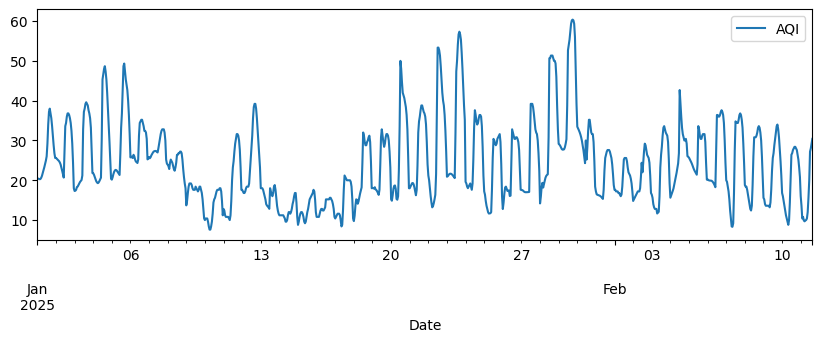

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ts[:1000].plot(ax=ax)

## Декомпозиция временного ряда
Разложим временной ряд на:
- тренд
- сезонную компоненту
- остатки

In [7]:
decomposition = STL(ts['AQI'], period=24)
res = decomposition.fit()
res

In [8]:
trend = res.trend
trend.head(3)

Date
2025-01-01 00:00:00+00:00    24.618610
2025-01-01 01:00:00+00:00    24.796552
2025-01-01 02:00:00+00:00    24.973338
Name: trend, dtype: float64

In [9]:
seasonal = res.seasonal
seasonal.head(3)

Date
2025-01-01 00:00:00+00:00   -3.732553
2025-01-01 01:00:00+00:00   -4.004140
2025-01-01 02:00:00+00:00   -4.264748
Name: season, dtype: float64

In [10]:
resid = res.resid
resid.head(3)

Date
2025-01-01 00:00:00+00:00   -0.402720
2025-01-01 01:00:00+00:00   -0.367412
2025-01-01 02:00:00+00:00   -0.375258
Name: resid, dtype: float64

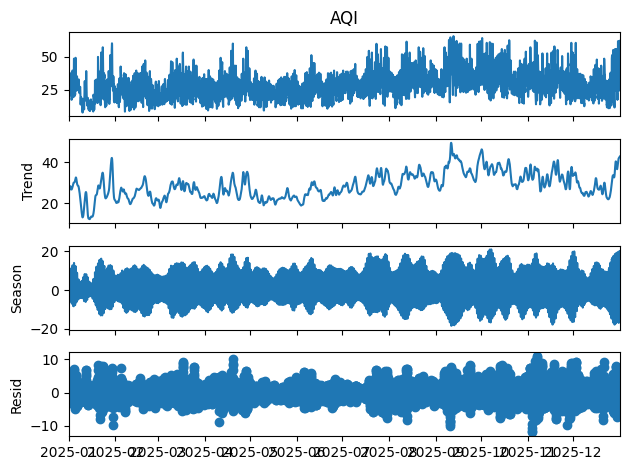

In [11]:
res.plot()
plt.show()

## Модель для прогноза по временному ряду

Классическая постановка задачи - прогноз целевого признака на определенный срок. Будем строить прогноз AQI на 2 года.

Можно использовать множество моделей для предсказания временных рядов. Например: SARIMAX, ARIMA и др.


Хорошим методом будет подход на основе календарных признаков для обучения модели ML. Если неизвестно, какие еще признаки могут дать - это выход из трудного положения.

Выделяем из даты год, месяц, день, час в признаки для обучения

In [12]:
ts = ts.reset_index()
# ts['year'] = ts['Date'].dt.year
ts['month'] = ts['Date'].dt.month
ts['day'] = ts['Date'].dt.day
ts['hour'] = ts['Date'].dt.hour

X = ts[['hour', 'day', 'month']]
y = ts['AQI']

X.head(3)

,hour,day,month
0,0,1,1
1,1,1,1
2,2,1,1


После того, как мы получили табличные данные, может использовать любую модель. Например, линейную регрессию.

In [13]:
model = LinearRegression()
model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Генерируем будущий временной ряд

In [14]:
# Последняя дата в исходных данных
last_date = ts['Date'].max()

# Создаём будущие даты на 2 года вперёд (почасово)
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(hours=1),
    periods=2 * 365 * 24,
    freq='h'
)

future_df = pd.DataFrame({'Date': future_dates})

In [15]:
# future_df['year'] = future_df['Date'].dt.year
future_df['month'] = future_df['Date'].dt.month
future_df['day'] = future_df['Date'].dt.day
future_df['hour'] = future_df['Date'].dt.hour

X_test = future_df[['hour', 'day', 'month']]

X_test.head(3)

,hour,day,month
0,0,1,1
1,1,1,1
2,2,1,1


## Инференс

In [16]:
y_pred = model.predict(X_test)

## Визуализация прогноза

Чтобы график выглядел красивым, отсечем часть исторических данных

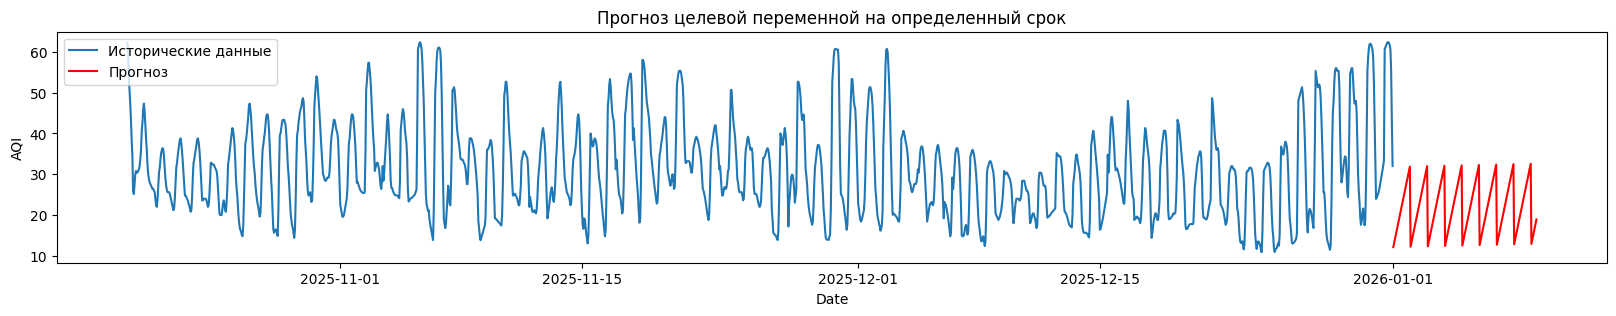

In [17]:
plt.figure(figsize=(20, 3))

sns.lineplot(data=ts.iloc[7000:], x='Date', y='AQI', label='Исторические данные')
sns.lineplot(x=future_df['Date'].iloc[:200], y=y_pred[:200], color='red', label='Прогноз')
plt.legend()
plt.title('Прогноз целевой переменной на определенный срок');

Такой прогноз выходит не очень красивым, но сильно экономит время. Для получения баллов за простой прогноз - отлично.

Но если нужно построить качественный прогноз, используем модель SARIMAX.

## SARIMAX

In [18]:
# Приводим данные к знакомому формату
ts = ts.set_index('Date')
ts = ts['AQI']
ts.head()

Date
2025-01-01 00:00:00+00:00    20.483337
2025-01-01 01:00:00+00:00    20.425000
2025-01-01 02:00:00+00:00    20.333332
2025-01-01 03:00:00+00:00    20.258335
2025-01-01 04:00:00+00:00    20.316668
Name: AQI, dtype: float64

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    y,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24),
)

results = model.fit()
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                AQI   No. Observations:                 8760
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -16284.538
Date:                            Mon, 12 Jan 2026   AIC                          32579.077
Time:                                    15:25:06   BIC                          32614.452
Sample:                                         0   HQIC                         32591.132
                                           - 8760                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2581      0.015     17.444      0.000       0.229       0.287
ma.L1          0.2276      0.015   

In [20]:
# Прогноз на 2 года вперёд
n_steps = 2 * 365 * 24  # 2 года, почасово, тк данные по часу

forecast = results.get_forecast(steps=n_steps)

forecast_mean = forecast.predicted_mean

future_index = pd.date_range(
    start=ts.index[-1] + pd.Timedelta(hours=1),
    periods=n_steps,
    freq='h'
)

forecast_mean.index = future_index
forecast_mean.head()

2026-01-01 00:00:00+00:00    25.692463
2026-01-01 01:00:00+00:00    24.738213
2026-01-01 02:00:00+00:00    24.125265
2026-01-01 03:00:00+00:00    23.909413
2026-01-01 04:00:00+00:00    24.042464
Freq: h, Name: predicted_mean, dtype: float64

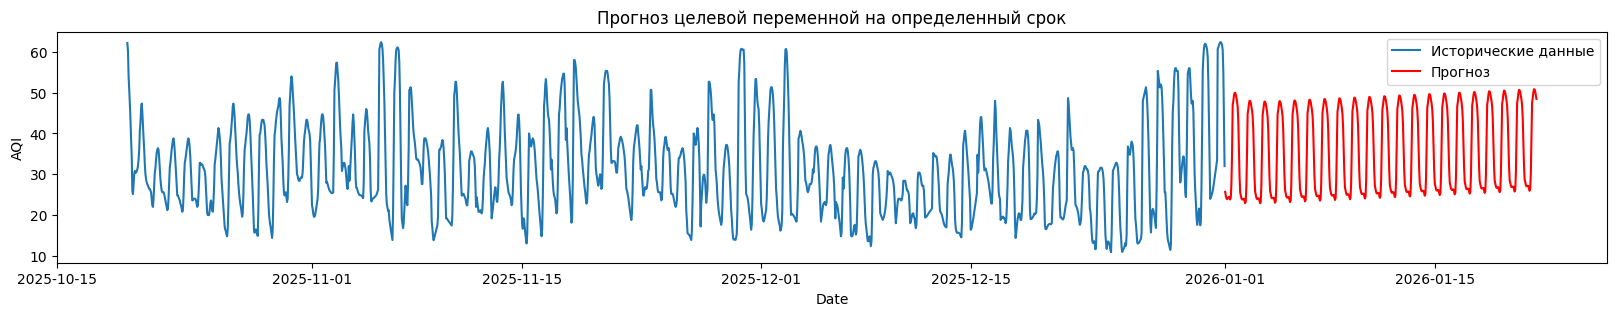

In [21]:
plt.figure(figsize=(20, 3))

ts = ts.reset_index()
forecast_mean.reset_index()

sns.lineplot(data=ts.iloc[7000:], x='Date', y='AQI', label='Исторические данные')
sns.lineplot(x=forecast_mean.index[:500], y=forecast_mean[:500], color='red', label='Прогноз')
plt.legend()
plt.title('Прогноз целевой переменной на определенный срок');

Модель уловила сезонность и тренд, и сделала прогноз лучше линейной регрессии.